# Part 3: Characterizing TR heterozygosity patterns

This notebook generates the items listed below. For preprocessing see:
* `../het-stats/readme.sh`: computes per-locus, per-population, heterozygosity/num allele stats

Figures:
* Figure 3a-e: lengths vs. heterozygosity

Supplementary Figures:
* Supp Figure 14: length vs. het by population

In [1]:
####### Set up #########

%pylab inline

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

import os
import pandas as pd
import scipy.stats
import seaborn as sns

PLOTDIR = "pdfs"

dfs = []
for chrom in range(1, 23):
    if not os.path.exists("../het-stats/chr%s.period.tab"%chrom): continue
    data = pd.read_csv("../het-stats/chr%s.stats.tab"%chrom, sep="\t")
    dfs.append(data)
data = pd.concat(dfs)

motifs = pd.read_csv("../het-stats/motif_info.tab", sep="\t", names=["chrom", "start","period","motif"])
data = pd.merge(data, motifs, on=["chrom","start"])
data["reflen"] = data.apply(lambda x: (x["end"]-x["start"]+1)/x["period"], 1)
data["reflen-bp"] = data.apply(lambda x: (x["end"]-x["start"]), 1)

data = data[(data["motif"].apply(type)==str)]

Populating the interactive namespace from numpy and matplotlib


# Annotate data frame with longest perfect repeat stretch

In [2]:
import pyfaidx
window = 5 # buffer around each STR to check
genome = pyfaidx.Fasta("/storage/resources/dbase/human/GRCh38/GRCh38_full_analysis_set_plus_decoy_hla.fa")
data["refseq"] = data.apply(lambda x: str(genome[x["chrom"]][x["start"]-window:x["end"]+window]), 1)

In [3]:
def longest_perfect_repeat(ref, motif):
    max_matches = []
    strand_ref = ""
    
    for x in ref:
        if x == 'T':
            strand_ref += "A"
        if x == "A":
            strand_ref += "T"
        if x == "G":
            strand_ref += "C"
        if x == "C":
            strand_ref += "G"
    strand_ref = strand_ref[::-1]
    
    for ref_ in [ref, strand_ref]:
        for mot in [motif, motif[::-1]]:
                i = 0
                match = 0
                max_match = 0
        
                while True:
                    if i >= len(ref_):
                        break
                    for j in range(0,len(motif)):
                        k = i
                        while True:
                            while j < len(mot) and k < len(ref_) and ref_[k] == mot[j]:
                                k += 1
                                j += 1
                                match += 1
                            max_match = max(max_match, match)
                            if j == len(motif):
                                j = 0
                                i = k
                            else:
                                if j == len(motif) - 1:
                                    i += 1
                                match = 0
                                break

                        j = 0
                max_matches.append(max_match)

    return max(max_matches)
data["longest_repeat_stretch"] = data.apply(lambda x: longest_perfect_repeat(x["refseq"], x["motif"]), 1)
data.to_csv("data_longest_stretch.csv")

# Figure 3, panels a-e

In [4]:
# Plot reflen vs. het by period, overall and for each population
LABSIZE = 18
TICKSIZE = 14

def GetMatchesMotif(motif, motiflist):
    for m in motiflist:
        if m == "ALL": return True
        elif type(m) == int or type(m) == float:
            if len(motif)==m: return True
        elif m == "vntr":
            if len(motif)> 6: return True
        else:
            if m == motif: return True
    return False
    
def PlotLenVsHet(data, ax=None, lencol="reflen", lineskip=1, pop=None, motifs=None, colors=None, figname=None):
    """
    Plot length vs. het
    If pop=None, use het-ALL. else use het-${pop}
    motifs is a list of motifs. or 1, 2, 3 etc. for
    all motifs with that length. Use "vntr" for 7+
    """
    if lencol == "reflen":
        MINLEN = 10
        MAXLEN = 30
    else:
        MINLEN = 10
        MAXLEN = 80
    if pop is None:
        col = "het-ALL"
    else: col = "het-%s"%pop
    if ax is None:
        fig = plt.figure()
        fig.set_size_inches((8, 6))
        ax = fig.add_subplot(111)
    if motifs is None:
        motifs = ["ALL"]
        colors = ["black"]
    for i in range(len(motifs)):
        m = motifs[i]
        print("m=%s n=%s"%(m, data[(data["motif"].apply(lambda x: GetMatchesMotif(x, [m]), 1))].shape[0]))
        lenbins = range(MINLEN, MAXLEN+1)
        if lencol == "reflen":
            lenbins = np.arange(MINLEN, MAXLEN, 1)
        else:
            if (m in [1,2,3] or (type(m)==str and len(m) <3)) and m != "vntr" and (m != "ALL"):
                lenbins = range(MINLEN, MAXLEN+1)
            else:
                lenbins = np.arange(MINLEN, MAXLEN, 1)  # could go lower resolution here if we want
        color = colors[i]
        xvals = []
        yvals = []
        for j in range(len(lenbins)-1):
            lb = lenbins[j]
            ub = lenbins[j+1]
            xx = data[(data[lencol]>=lb) & (data[lencol]<ub) &
                                      (data["motif"].apply(lambda x: GetMatchesMotif(x, [m]), 1))]
            if xx.shape[0] > 10:
                xvals.append(lb)
                yvals.append(np.mean(xx[col]))
        ax.plot(xvals, yvals, color=color, label=m)
    if lineskip is not None:
        for i in range(MINLEN, MAXLEN+1, lineskip):
            ax.axvline(x=i, linewidth=0.5, color="gray")
    if lencol == "lencol":
        ax.set_xlabel("Length", size=LABSIZE)
    else:
        ax.set_xlabel("Length (bp)", size=LABSIZE)
    ax.set_ylabel("Mean heterozygosity", size=LABSIZE)
    ax.legend(loc="lower right")
    if pop is not None: ax.set_title(pop)
    ax.set_xticklabels([int(item) for item in ax.get_xticks()], size=TICKSIZE)
    ax.set_yticklabels(["%.1f"%item for item in ax.get_yticks()], size=TICKSIZE)
    if figname is not None and ax is None: fig.savefig(figname)
        
# Plot reflen vs. het by period, overall and for each population

def GetMatchesMotif(motif, motiflist):
    for m in motiflist:
        if m == "ALL": return True
        elif type(m) == int or type(m) == float:
            if len(motif)==m: return True
        elif m == "vntr":
            if len(motif)> 6: return True
        else:
            if m == motif: return True
    return False
    
def PlotLenVsNum(data, ax=None, lencol="reflen", motifs=None, colors=None, figname=None):
    """
    Plot length vs. num loci
    motifs is a list of motifs. or 1, 2, 3 etc. for
    all motifs with that length. Use "vntr" for 7+
    """
    if lencol == "reflen":
        MINLEN = 10
        MAXLEN = 30
    else:
        MINLEN = 10
        MAXLEN = 80
    if ax is None:
        fig = plt.figure()
        fig.set_size_inches((8, 3))
        ax = fig.add_subplot(111)
    if motifs is None:
        motifs = ["ALL"]
        colors = ["black"]
    for i in range(len(motifs)):
        m = motifs[i]
        lenbins = range(MINLEN, MAXLEN+1)
        if lencol == "reflen":
            lenbins = np.arange(MINLEN, MAXLEN, 1)
        else:
            if (m in [1,2,3] or (type(m)==str and len(m) <3)) and m != "vntr" and (m != "ALL"):
                lenbins = range(MINLEN, MAXLEN+1)
            else:
                lenbins = np.arange(MINLEN, MAXLEN, 1)  # could go lower resolution here if we want
        color = colors[i]
        xvals = []
        yvals = []
        for j in range(len(lenbins)-1):
            lb = lenbins[j]
            ub = lenbins[j+1]
            xx = data[(data[lencol]>=lb) & (data[lencol]<ub) &
                                      (data["motif"].apply(lambda x: GetMatchesMotif(x, [m]), 1))]
            
            if xx.shape[0] > 10:
                xvals.append(lb)
                yvals.append(xx.shape[0])
        ax.plot(xvals, yvals, color=color, label=m)
    if lencol == "lencol":
        ax.set_xlabel("Length", size=LABSIZE)
    else:
        ax.set_xlabel("Length (bp)", size=LABSIZE)
    ax.set_ylabel("Num. TRs", size=LABSIZE)
    plt.yscale("log")
    ax.legend(loc="lower right")
    ax.set_xticklabels([int(item) for item in ax.get_xticks()], size=TICKSIZE)
    ax.set_yticklabels(ax.get_yticklabels(), size=TICKSIZE)
    if figname is not None and ax is None: fig.savefig(figname)

colors = ["red","orange","gold","green","blue","purple","pink","brown","cyan","gray"]

m=1 n=711781
m=2 n=279356
m=3 n=149630
m=4 n=383494
m=5 n=123552
m=6 n=64273
m=vntr n=8949
m=AC n=145018
m=AT n=74331
m=AG n=59151
m=CG n=824
m=AA n=23
m=CC n=9
m=AAT n=56206
m=AAC n=36353
m=AGG n=14671
m=AAG n=10134
m=AGC n=8685
m=ACC n=8653
m=ATC n=8594
m=CCG n=4249
m=ACT n=1965
m=ACG n=94
m=AAAT n=114194
m=AAAC n=71585
m=AAAG n=39379
m=AATG n=30189
m=AAGG n=20406
m=AGGG n=17269
m=ACAT n=11882
m=AGAT n=10777
m=AGGC n=9381
m=AATT n=8569
m=AAAAC n=43758
m=AAAAT n=31532
m=AAAAG n=16504
m=AAATT n=3141
m=AGGGG n=2191
m=AAAGG n=2055
m=AATAT n=1840
m=AAGGG n=1509
m=ACCCC n=1505
m=AGAGG n=1287


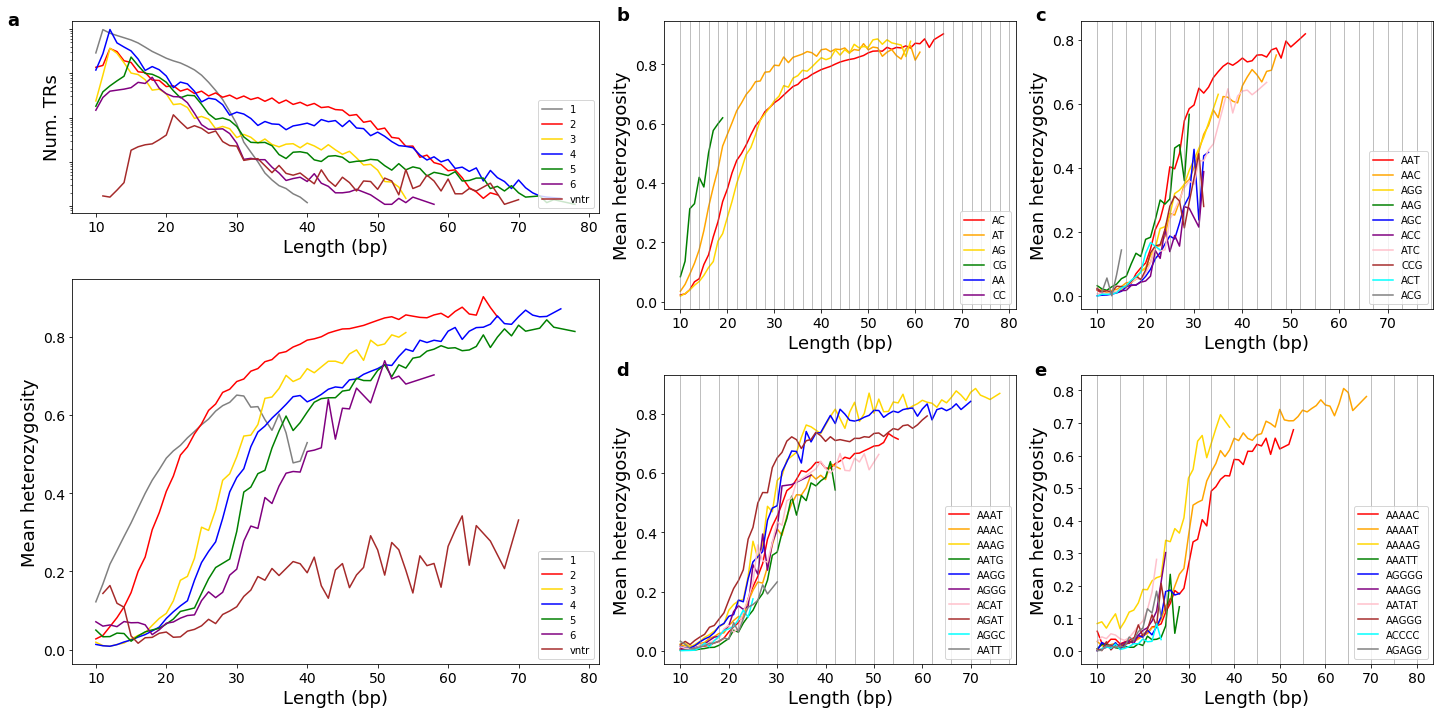

In [5]:
pltdata = data
################## Figure 3 ##############
fig = plt.figure()
fig.set_size_inches((20, 10))

# Overall grid spec
gs = GridSpec(2, 3, width_ratios=[1.5,1, 1], height_ratios=[1,1])

# Nested grid spec for figures on the left
gs00 = GridSpecFromSubplotSpec(2, 1, height_ratios=[1, 2], subplot_spec=gs[:,0])

# Plot overall - num
ax = fig.add_subplot(gs00[0,0])
PlotLenVsNum(pltdata, ax=ax, motifs=[1,2,3,4,5,6,"vntr"], 
             colors=["gray","red","gold","blue","green","purple","brown"],
             lencol="longest_repeat_stretch");
ax.text(-0.1, 1.05, "a", transform=ax.transAxes, 
                     size=18, fontweight="bold", family="sans-serif",
                    va="top", ha="right")

# Plot overall - het
ax = fig.add_subplot(gs00[1,0])
PlotLenVsHet(pltdata, ax=ax, motifs=[1,2,3,4,5,6,"vntr"], 
             colors=["gray","red","gold","blue","green","purple","brown"], lineskip=None,
             lencol="longest_repeat_stretch");

for period in [2,3,4,5]:
    if period == 2:
        ax = ax=fig.add_subplot(gs[0,1])
        labtext = "b"
    if period == 3:
        ax=fig.add_subplot(gs[0,2])
        labtext = "c"
    if period == 4:
        ax=fig.add_subplot(gs[1,1])
        labtext = "d"
    if period == 5:
        ax=fig.add_subplot(gs[1,2])
        labtext = "e"
        
    motifs = list(pltdata[pltdata["period"]==period].groupby("motif", as_index=False).agg({"start": len}).sort_values("start", ascending=False).head(n=10)["motif"])
    PlotLenVsHet(pltdata, ax=ax, motifs=motifs, 
                 colors=colors, 
                 lineskip=period,
             lencol="longest_repeat_stretch");
    
    ax.text(-0.1, 1.05, labtext, transform=ax.transAxes, 
                     size=18, fontweight="bold", family="sans-serif",
                    va="top", ha="right")

fig.tight_layout()
fig.savefig(os.path.join(PLOTDIR, "Figure3a-e.pdf"));

# Supp Figure 14 - length vs. het by population

m=1 n=711781
m=2 n=279356
m=3 n=149630
m=4 n=383494
m=5 n=123552
m=6 n=64273
m=vntr n=8949
m=1 n=711781
m=2 n=279356
m=3 n=149630
m=4 n=383494
m=5 n=123552
m=6 n=64273
m=vntr n=8949
m=1 n=711781
m=2 n=279356
m=3 n=149630
m=4 n=383494
m=5 n=123552
m=6 n=64273
m=vntr n=8949
m=1 n=711781
m=2 n=279356
m=3 n=149630
m=4 n=383494
m=5 n=123552
m=6 n=64273
m=vntr n=8949
m=1 n=711781
m=2 n=279356
m=3 n=149630
m=4 n=383494
m=5 n=123552
m=6 n=64273
m=vntr n=8949
m=1 n=711781
m=2 n=279356
m=3 n=149630
m=4 n=383494
m=5 n=123552
m=6 n=64273
m=vntr n=8949


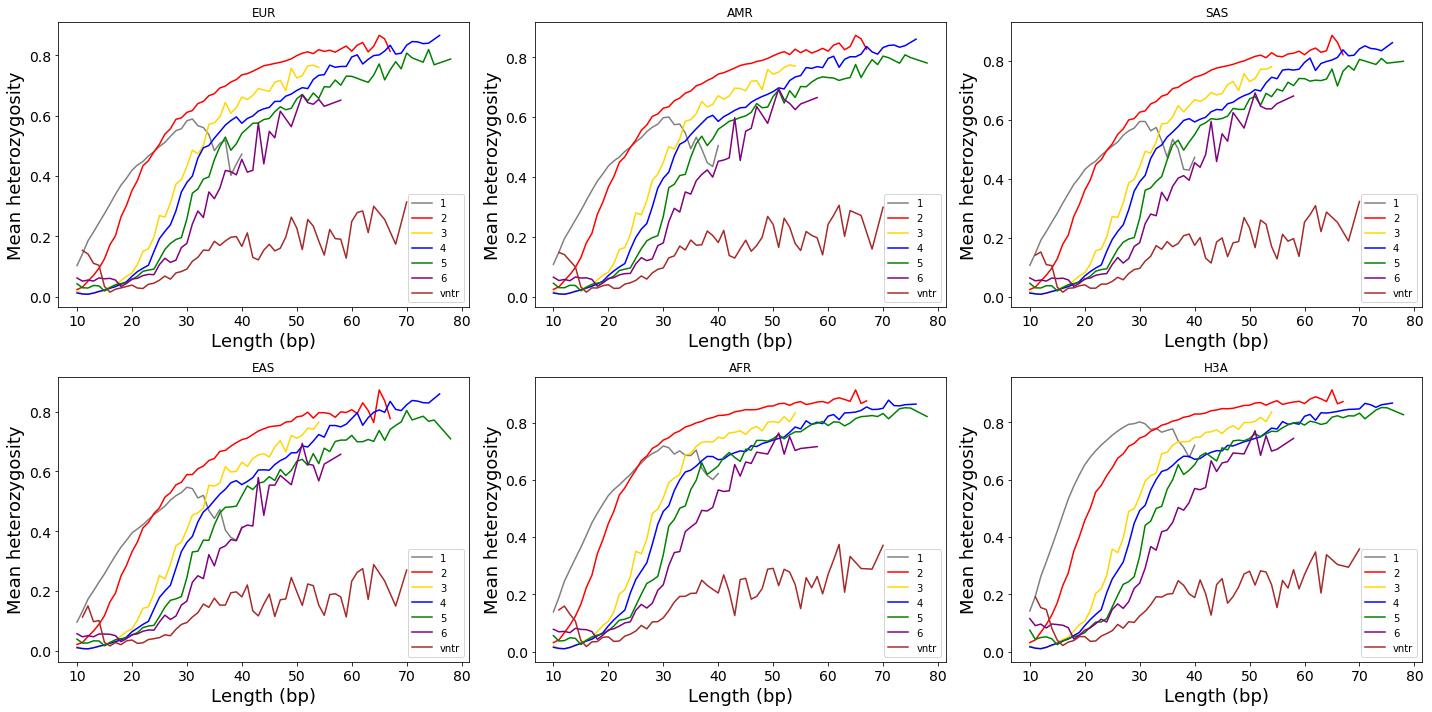

In [6]:
fig = plt.figure()
fig.set_size_inches((20, 10))

popind = 1
for pop in ["EUR","AMR","SAS","EAS","AFR","H3A"]:
    ax = fig.add_subplot(2, 3, popind)
    PlotLenVsHet(pltdata, ax=ax, motifs=[1,2,3,4,5,6,"vntr"], pop=pop, lineskip=None, 
             lencol="longest_repeat_stretch", colors=["gray","red","gold","blue","green","purple","brown"]);          
    popind += 1

fig.tight_layout()
fig.savefig(os.path.join(PLOTDIR, "SuppFigure14-LengthVsHetByPop.pdf"));